In [44]:
import sys
sys.path.append("v2_Assignment_Codes")  # Add the folder to the search path

#load data
from v2_data import get_fixed_data
from PriceProcess import price_model
from WindProcess import wind_model
from utils import generate_time_series,generate_experiment_series

import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import *

%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 13})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Task 0

In [45]:
data = get_fixed_data()
T = data['num_timeslots']

In [ ]:
# ensure we always use the same time series for all tasks and experiments
prices,winds = generate_experiment_series()

## Optimal in hindsight solution on an example time series

In [47]:
def solve_model(price,wind,T,h_0,e_on_init,t_start=0): 

    #ranges
    T_range = range(T)
    Tm1_range = range(-1,T-1)

    # Create a model
    model = ConcreteModel()
    # Declare indexed variable for the price
    model.p_grid = Var(T_range, within=NonNegativeReals,name='p_grid')
    model.e_h2p = Var(T_range, within=NonNegativeReals,name='e_h2p')
    model.e_p2h = Var(T_range, within=NonNegativeReals,name='e_p2h')
    model.e_on = Var(Tm1_range, within=Binary,name='e_on')
    #model.e_activate = Var(range(T), within=Binary,name='e_activate',initialize=0)

    model.h = Var(range(T), within=NonNegativeReals,bounds=(0,data['hydrogen_capacity']),name='h')

    # Objective function
    def objective_rule(model):
        return sum(price[t] * model.p_grid[t] + data['electrolyzer_cost']*model.e_on[t-1] for t in range(T))

    model.profit = Objective(rule=objective_rule, sense=minimize)

    model.DemandConstraint = Constraint(T_range, rule=lambda model, t: model.p_grid[t] + wind[t] + data['conversion_h2p']*model.e_h2p[t] - model.e_p2h[t] >= data['demand_schedule'][t_start+t])

    # contraints

    model.h_contraint = Constraint(range(T-1),expr=lambda model, t: model.h[t+1] == model.h[t]+data['conversion_p2h']*model.e_p2h[t]-model.e_h2p[t])

    model.p2h_constraint = Constraint(T_range,rule=lambda model,t: model.e_h2p[t] <= model.h[t])
    model.p2h_constraint2 = Constraint(T_range,rule=lambda model,t: data['conversion_h2p']*model.e_h2p[t] <= data['h2p_max_rate'])

    model.conversion_contraint = Constraint(T_range,rule=lambda model,t: data['conversion_p2h'] * model.e_p2h[t] <= data['p2h_max_rate']*model.e_on[t-1])

    model.tank_start = Constraint(expr=model.h[0] == h_0)

    model.electrolyser_start = Constraint(expr=model.e_on[-1] == e_on_init)

    # Create a solver
    solver = SolverFactory('gurobi')  # Make sure Gurobi is installed and properly configured

    # Solve the model
    results = solver.solve(model, tee=False)
    return results,model


Optimal solution found
Variable values:

Objective value: 519.228



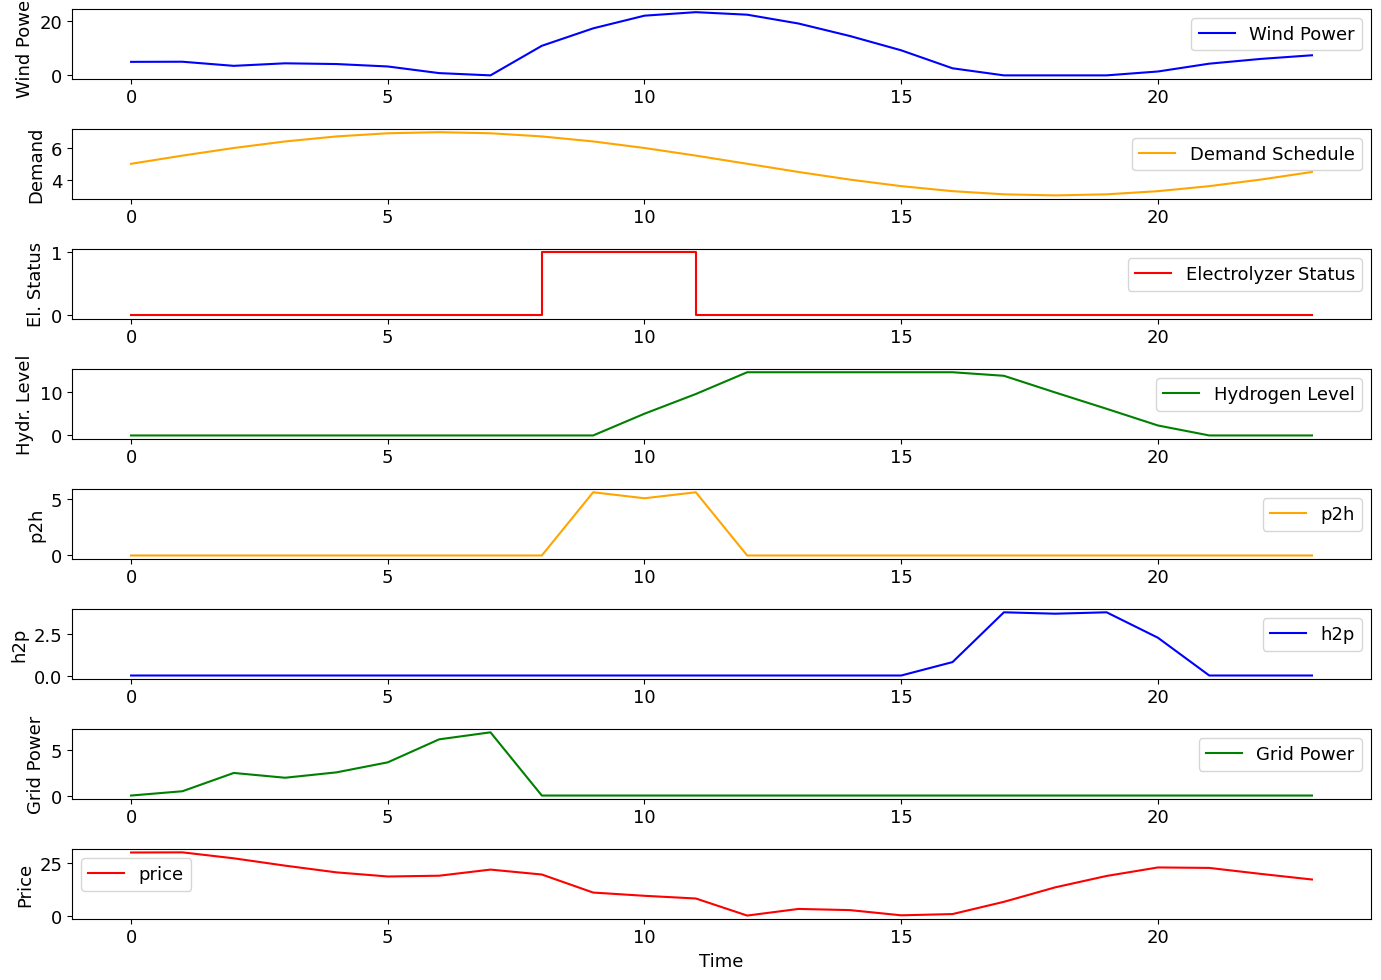

In [48]:
selected_prices = prices[8]
selected_winds = winds[8]

results,model = solve_model(selected_prices,selected_winds,T,0,0)

# Check if an optimal solution was found
if results.solver.termination_condition == TerminationCondition.optimal:
    print("Optimal solution found")

    # Print out variable values and objective value
    print("Variable values:")
    p_grid_values = [value(model.p_grid[t]) for t in range(T)]
    e_h2p_values = [value(model.e_h2p[t]) for t in range(T)]
    e_p2h_values = [value(model.e_p2h[t]) for t in range(T)]
    e_on_values = [value(model.e_on[t]) for t in range(-1,T-1)]
    h_values = [value(model.h[t]) for t in range(T)]
    print(f"\nObjective value: {value(model.profit):.3f}\n")
else:
    print("No optimal solution found.")

times = range(T)
wind_trajectory = selected_winds
price_trajectory = selected_prices

# Plot results
plt.figure(figsize=(14, 10))

plt.subplot(8, 1, 1)
plt.plot(times, wind_trajectory, label="Wind Power", color="blue")
plt.ylabel("Wind Power")
plt.legend()

plt.subplot(8, 1, 2)
plt.plot(times, data['demand_schedule'], label="Demand Schedule", color="orange")
plt.ylabel("Demand")
plt.legend()

plt.subplot(8, 1, 3)
plt.step(times, e_on_values[1:]+ [e_on_values[-1]], label="Electrolyzer Status", color="red", where="post")
plt.ylabel("El. Status")
plt.legend()


plt.subplot(8, 1, 4)
plt.plot(times, h_values, label="Hydrogen Level", color="green")
plt.ylabel("Hydr. Level")
plt.legend()


plt.subplot(8, 1, 5)
plt.plot(times, e_p2h_values, label="p2h", color="orange")
plt.ylabel("p2h")
plt.legend()


plt.subplot(8, 1, 6)
plt.plot(times, e_h2p_values, label="h2p", color="blue")
plt.ylabel("h2p")
plt.legend()


plt.subplot(8, 1, 7)
plt.plot(times, p_grid_values, label="Grid Power", color="green")
plt.ylabel("Grid Power")
plt.legend()

plt.subplot(8, 1, 8)
plt.plot(times, price_trajectory, label="price", color="red")
plt.ylabel("Price")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.savefig("figures/task_0_1.pdf", format="pdf", bbox_inches="tight")
plt.show()




Optimal solution found
Variable values:

Objective value: 3.000



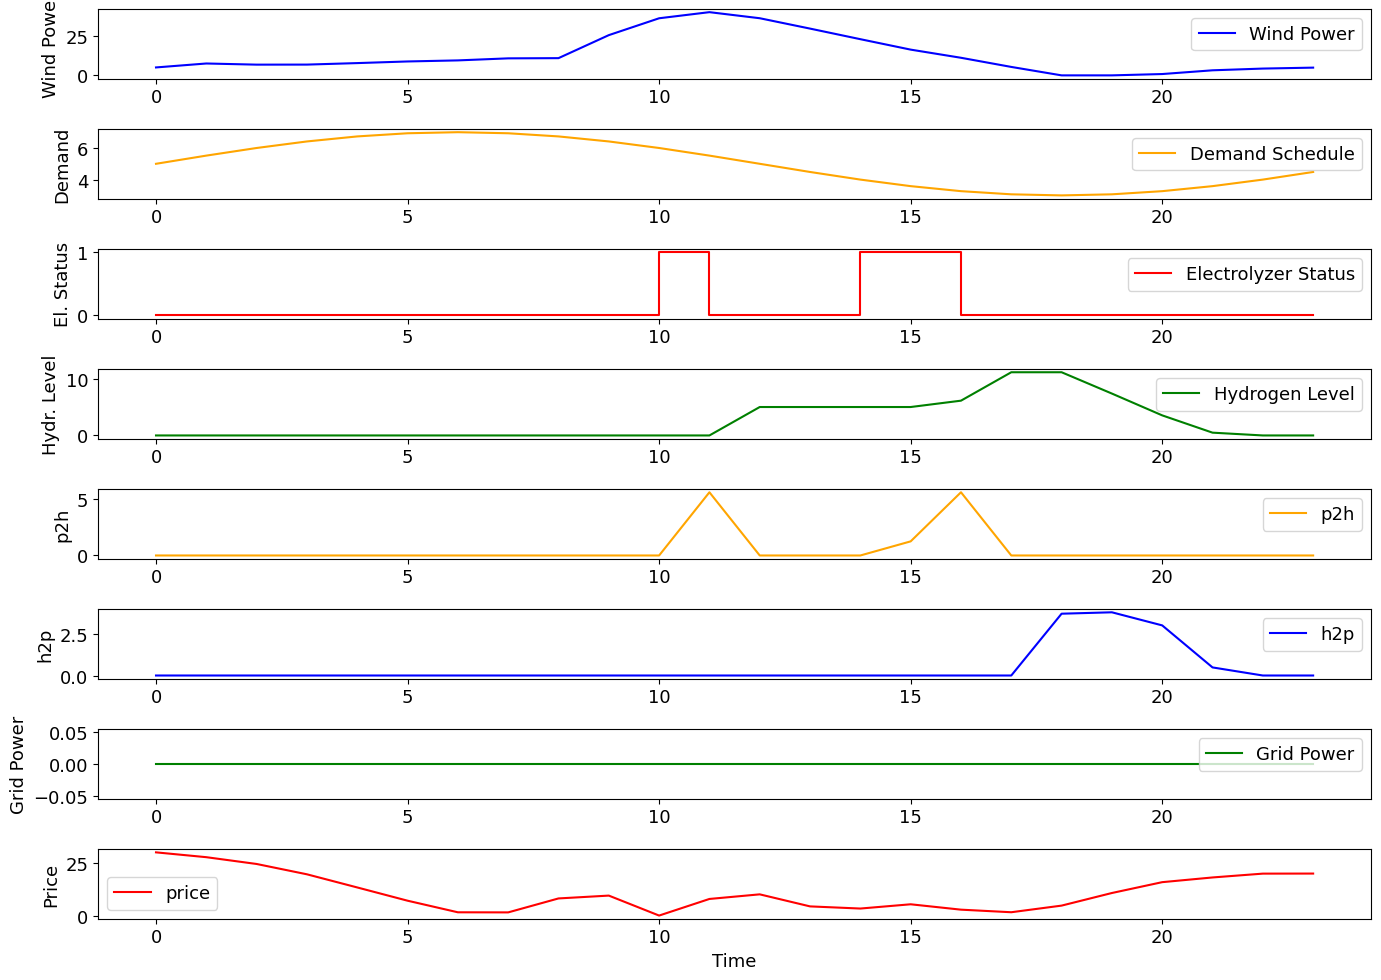

In [49]:
selected_prices = prices[0]
selected_winds = winds[0]

results,model = solve_model(selected_prices,selected_winds,T,0,0)

# Check if an optimal solution was found
if results.solver.termination_condition == TerminationCondition.optimal:
    print("Optimal solution found")

    # Print out variable values and objective value
    print("Variable values:")
    p_grid_values = [value(model.p_grid[t]) for t in range(T)]
    e_h2p_values = [value(model.e_h2p[t]) for t in range(T)]
    e_p2h_values = [value(model.e_p2h[t]) for t in range(T)]
    e_on_values = [value(model.e_on[t]) for t in range(-1,T-1)]
    h_values = [value(model.h[t]) for t in range(T)]
    print(f"\nObjective value: {value(model.profit):.3f}\n")
else:
    print("No optimal solution found.")

times = range(T)
wind_trajectory = selected_winds
price_trajectory = selected_prices

# Plot results
plt.figure(figsize=(14, 10))

plt.subplot(8, 1, 1)
plt.plot(times, wind_trajectory, label="Wind Power", color="blue")
plt.ylabel("Wind Power")
plt.legend()

plt.subplot(8, 1, 2)
plt.plot(times, data['demand_schedule'], label="Demand Schedule", color="orange")
plt.ylabel("Demand")
plt.legend()

plt.subplot(8, 1, 3)
plt.step(times, e_on_values[1:]+ [e_on_values[-1]], label="Electrolyzer Status", color="red", where="post")
plt.ylabel("El. Status")
plt.legend()


plt.subplot(8, 1, 4)
plt.plot(times, h_values, label="Hydrogen Level", color="green")
plt.ylabel("Hydr. Level")
plt.legend()


plt.subplot(8, 1, 5)
plt.plot(times, e_p2h_values, label="p2h", color="orange")
plt.ylabel("p2h")
plt.legend()


plt.subplot(8, 1, 6)
plt.plot(times, e_h2p_values, label="h2p", color="blue")
plt.ylabel("h2p")
plt.legend()


plt.subplot(8, 1, 7)
plt.plot(times, p_grid_values, label="Grid Power", color="green")
plt.ylabel("Grid Power")
plt.legend()

plt.subplot(8, 1, 8)
plt.plot(times, price_trajectory, label="price", color="red")
plt.ylabel("Price")
plt.xlabel("Time")
plt.legend()

plt.tight_layout()
plt.savefig("figures/task_0_2.pdf", format="pdf", bbox_inches="tight")
plt.show()


